In [32]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# SPECTER
from spectral_emd import compute_spectral_representation, cumulative_spectral_function
from spectral_emd import ds2


# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event




# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


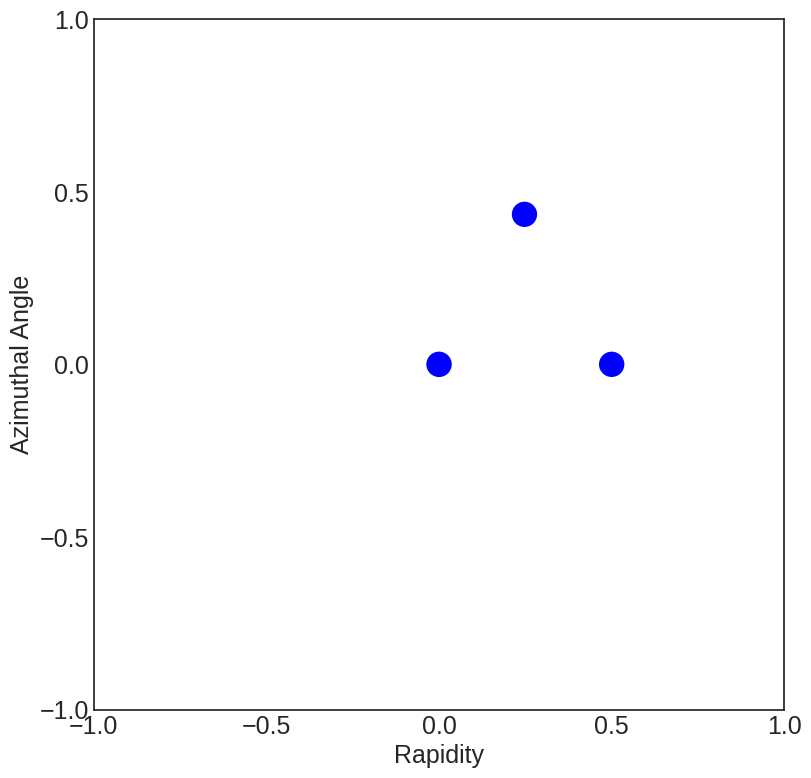

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [33]:
# Build 3 particle events
R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)

events = []
for i in range(N):
    temp = []
    for j in range(N):

        e = energies[j]
        epsilon = 1e-3
        zs = np.array([e, (1-e)/2 + epsilon, (1-e)/2 - epsilon])
        points = np.array([
                            (0.0, 0.0),
                            (R/2, 0.0),
                            (R*np.cos(angles[i])/2 * (1 + epsilon), R*np.sin(angles[i])/2  * (1 + epsilon))
                ])
        temp.append((points, zs))
    events.append(temp)

triangle_event = events[60][60]
plot_event(triangle_event[0], triangle_event[1], R, color = "blue")




In [34]:
# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables["2-Subjettiness"]


# Collect our observables in one dictionary
observables = {}
observables["2-Subjettiness"] = _2subjettiness

# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


EMDs = []
for (i,batch) in enumerate(events):

    temp = []
    print("BATCH: %d" % i)


    dataset_emds, dataset_params = shaper.calculate(batch, epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)
    for j in range(N):
        e = dataset_params["2-Subjettiness"][j]["EMD"]
        temp.append(e)

    EMDs.append(temp)

EMDs = np.array(EMDs)

BATCH: 0
Observable: 2-Subjettiness Epoch 0 Mean Loss = 2.8029950388492997e-05 Elapsed time = 0.030s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 1 Mean Loss = 2.713606808146807e-07 Elapsed time = 0.065s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 2 Mean Loss = 4.090242446181946e-05 Elapsed time = 0.127s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 3 Mean Loss = 6.342700503283696e-06 Elapsed time = 0.189s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 4 Mean Loss = 1.7792880518956937e-05 Elapsed time = 0.225s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 5 Mean Loss = 2.6466453543131745e-05 Elapsed time = 0.255s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 6 Mean Loss = 1.3817702920783227e-05 Elapsed time = 0.283s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 7 Mean Loss = 2.2818295797656498e-06 Elapsed time = 0.313s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 8 Mean Loss = 5.711804662

/tmp/ipykernel_1263621/3920928567.py:5: RuntimeWarning: invalid value encountered in sqrt
  plt.contourf(angles, energies, np.log(np.sqrt(EMDs.T) * 2), np.linspace(-5, 1, 25), cmap = "Reds", extend = "both")
/tmp/ipykernel_1263621/3920928567.py:5: RuntimeWarning: divide by zero encountered in log
  plt.contourf(angles, energies, np.log(np.sqrt(EMDs.T) * 2), np.linspace(-5, 1, 25), cmap = "Reds", extend = "both")


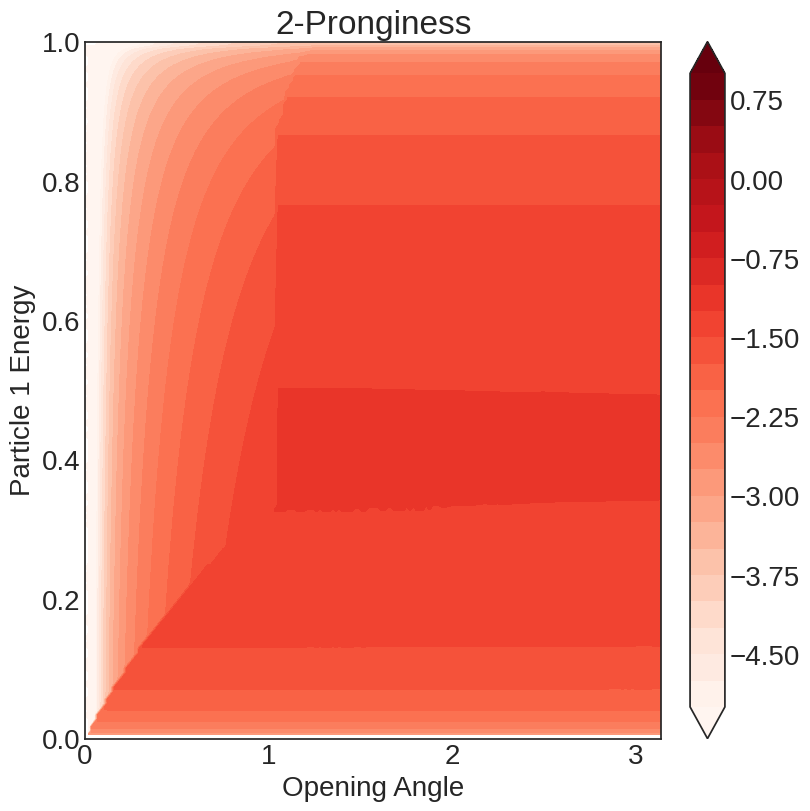

In [35]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


plt.contourf(angles, energies, np.log(np.sqrt(EMDs.T) * 2), np.linspace(-5, 1, 25), cmap = "Reds", extend = "both")
plt.xlabel("Opening Angle")
plt.ylabel("Particle 1 Energy")
plt.colorbar()

plt.title("2-Pronginess")
plt.clim(-5, 1)
# plt.clabel("log$_{10}EMD$")

In [40]:
# sEMDs
from tqdm import tqdm

sEMDs = []


for angle in tqdm(range(N)):


    bee = []

    for energy in range(N):

        es = np.linspace(0,0.5, 100)
        omegas = np.array((0.5,))
        Es, Omegas = np.meshgrid(es, omegas)
        temp = np.zeros_like(Es)
    

        for (i, e) in enumerate(es):
            for (j, omega) in enumerate(omegas):

                s = compute_spectral_representation(events[angle][energy], type = "jet")
                s2 = np.array((   (0, 1 - e), (omega, e),     ))
                d = ds2(s, s2)
                temp[j,i] = d

        bee.append(np.amin(temp))
    sEMDs.append(bee)

sEMDs = np.array(sEMDs)

100%|██████████| 180/180 [02:59<00:00,  1.00it/s]


/tmp/ipykernel_1263621/1597015275.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)
/tmp/ipykernel_1263621/1597015275.py:5: RuntimeWarning: invalid value encountered in log10
  plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)


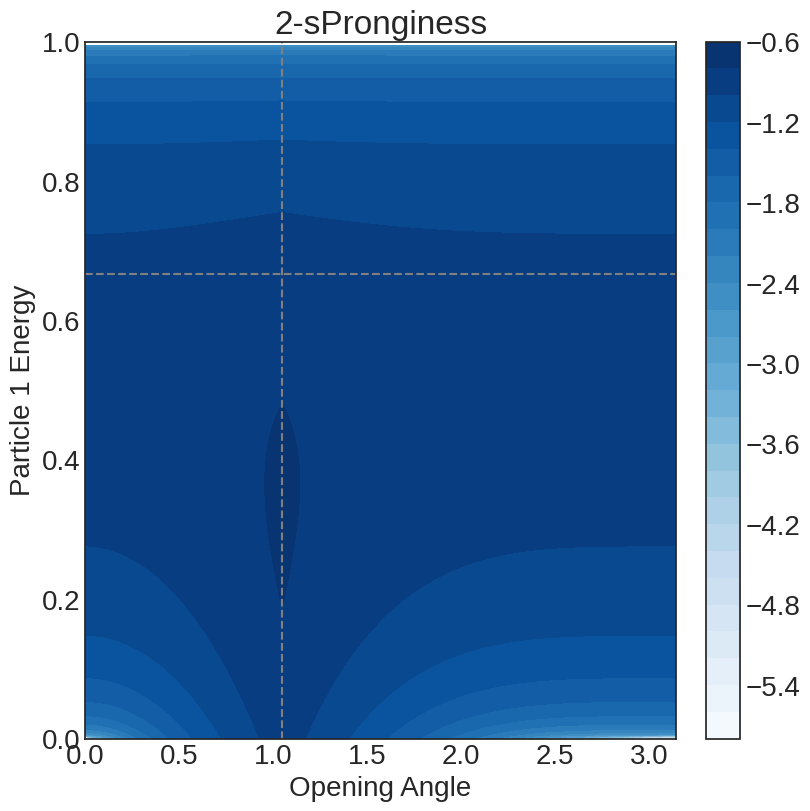

In [37]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)
plt.xlabel("Opening Angle")
plt.ylabel("Particle 1 Energy")
plt.axvline(np.pi/3, ls = "--", color = "grey")
plt.axhline(2/3, ls = "--", color = "grey")

plt.title("2-sPronginess")
plt.colorbar()
# plt.clabel("log$_{10}d^2$")

(180,) (180, 180)


Text(0, 0.5, 'Observable')

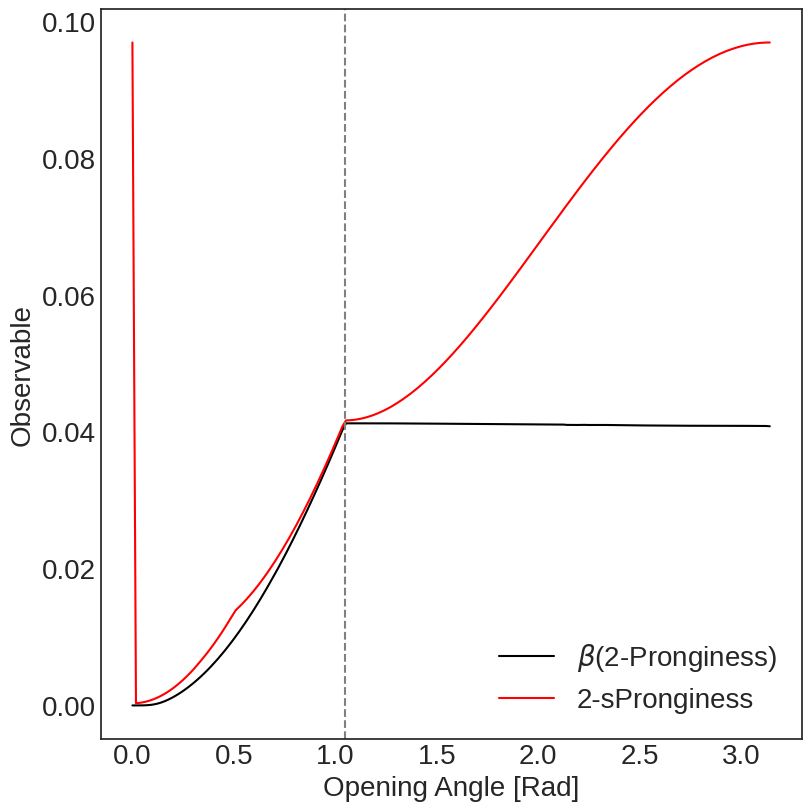

In [42]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

print(angles.shape, np.array(EMDs).shape)

plt.plot(angles, 2 * (np.array(EMDs.reshape(N,N)[:,60])), color = "black", label = r"$\beta$(2-Pronginess)")
plt.plot(angles, np.array(sEMDs.reshape(N,N)[:,60]), color = "red", label = "2-sPronginess")
plt.axvline(np.pi / 3, color = "grey", ls = "--")
plt.legend(frameon = False)

plt.xlabel("Opening Angle [Rad]")
plt.ylabel("Observable")

(99, 100)


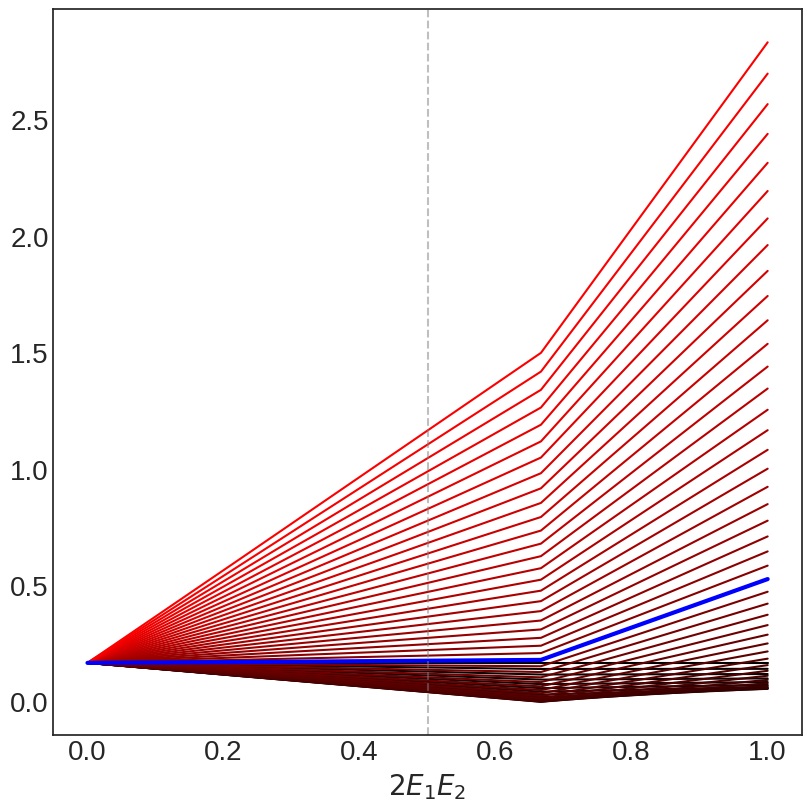

In [39]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

es = np.linspace(0,1, 100)
omegas = np.linspace(0,2, 99)
Es, Omegas = np.meshgrid(es, omegas)
temp = np.zeros_like(Es)

print(temp.shape)

for (i, e) in enumerate(es):
    for (j, omega) in enumerate(omegas):

        s = compute_spectral_representation(events[60][60], type = "jet")
        s2 = np.array((   (0, 1 - e), (omega, e),     ))
        d = ds2(s, s2)
        temp[j,i] = d


for (i, omega) in enumerate(omegas):
    if i % 2 == 0:
        plt.plot(es, temp[i,:], color = (i / len(omegas),0,0))

plt.plot(es, temp[50,:], color = (0,0,1), lw = 3)
plt.xlabel("$2E_1E_2$")
plt.axvline(0.5, color = "grey", alpha = 0.5, ls = "--")
